# Building with LangGraph

## What is LangGraph?

**LangGraph** is a library for building stateful, multi-step applications with LLMs using a graph-based approach. It's designed specifically for creating **AI agents** that can:

- Maintain conversation state across multiple turns
- Make decisions based on context
- Use external tools and APIs
- Handle complex workflows with conditional logic
- Remember past interactions

**Key Advantages Over Basic LLM Calls:**

1. **State Management** - Built-in conversation memory and context tracking
2. **Graph Structure** - Define complex flows with nodes, edges, and conditions
3. **Tool Integration** - Seamlessly connect LLMs to external functions
4. **Persistence** - Save and restore conversation states
5. **Visualization** - See your agent's architecture visually

**Use Cases:**
- Multi-turn conversational agents
- Research assistants with web search
- Autonomous task executors
- Complex decision-making systems
- Customer support bots with memory

In this notebook, we'll build increasingly sophisticated agents using local Ollama (llama3.2) instead of OpenAI.

## Building a ChatBot

### Understanding LangGraph Basics

**LangGraph** is a framework for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to create cyclic graphs for agent workflows.

**Key Components:**

**1. StateGraph** - The core structure that manages application state and flow
- Defines how data (state) flows between nodes
- Manages conversation history and context

**2. State (TypedDict)** - Application state definition
- `messages: Annotated[list, add_messages]` - Stores conversation history
- `add_messages` - Built-in reducer that intelligently merges messages

**3. Nodes** - Individual processing units
- `chatbot` node - Invokes the LLM with current state
- Returns updated state (new messages)

**4. Graph Flow**
- `set_entry_point("chatbot")` - Where the graph starts
- `set_finish_point("chatbot")` - Where the graph ends
- `compile()` - Builds the executable graph

**Simple ChatBot Architecture:**
```
START → chatbot node → END
```

This basic bot takes user input, processes it through the LLM, and returns a response.

In [1]:
pip install --upgrade -q langchain langchain-ollama langchain-community langgraph langgraph-checkpoint-sqlite

Note: you may need to restart the kernel to use updated packages.


In [2]:
from langgraph.graph import StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOllama(model='llama3.2', temperature=0.5)

# defining the chatbot node
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# adding the node to the graph
graph_builder.add_node("chatbot", chatbot)

# setting the entry and the finish points
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

## Visualizing the Graph

### Graph Visualization

LangGraph provides built-in visualization tools to understand your agent's architecture:

**Two Visualization Methods:**

1. **Mermaid Diagram (PNG)** - Visual flowchart
   - Uses `graph.get_graph().draw_mermaid_png()`
   - Shows nodes, edges, and flow direction
   - Great for documentation and presentations

2. **ASCII Diagram** - Text-based representation
   - Uses `graph.get_graph().draw_ascii()`
   - Works in any terminal/console
   - Useful for debugging and quick inspection

**Why Visualize?**
- Understand the agent's decision flow
- Debug complex multi-node graphs
- Communicate design to team members
- Verify conditional edges and loops are correct

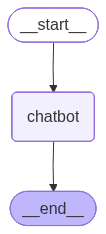

In [4]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
pip install -q grandalf

Note: you may need to restart the kernel to use updated packages.


In [6]:
print(graph.get_graph().draw_ascii())

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | chatbot |   
 +---------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


## Running the ChatBot

### Interactive Chat Loop

**How the ChatBot Runs:**

**`graph.stream()`** - Streams graph execution events
- Takes input: `{'messages': ('user', user_input)}`
- Returns events as the graph processes
- Each event contains updated state

**Event Processing:**
```python
for event in graph.stream({'messages': ('user', user_input)}):
    for value in event.values():
        print(value["messages"][-1].content)
```

- **Outer loop** - Iterates through graph execution steps
- **Inner loop** - Extracts values from each event
- **`messages[-1]`** - Gets the most recent message (assistant's response)

**Exit Conditions:**
- User types: `quit`, `exit`, `bye`, or `q`
- Breaks the loop and ends the session

This creates a continuous conversation where each message builds on the previous context.

In [7]:
while True:
    user_input = input('User: ')
    if user_input.lower() in ['quit', 'exit', 'bye',  'q']:
        print('Goodbye!')
        break

    for event in graph.stream({'messages': ('user', user_input)}):
        for value in event.values():
            print(f'Assistant: {value["messages"][-1].content}')
            print('-' * 20)

Assistant: The novel "Crime and Punishment" by Fyodor Dostoevsky is a complex and layered work that portrays several themes and ideas. Here are some of the most significant ones:

1. **The Nature of Morality**: The novel explores the question of morality and whether it can be justified through rational thought or if it's based on emotions, intuition, and personal values. The protagonist, Raskolnikov, grapples with this question as he weighs his own moral code against the consequences of his actions.
2. **Guilt and Redemption**: Through Raskolnikov's character, Dostoevsky portrays the psychological effects of guilt on an individual. As Raskolnikov struggles to come to terms with his crime, he undergoes a transformation from self-righteousness to self-awareness and ultimately seeks redemption.
3. **The Psychological Effects of Crime**: The novel highlights the devastating consequences of committing a serious crime, both for the perpetrator and the victim's family. It shows how crime can 

## Tavily AI

### Tavily AI - Search API for Agents

**Tavily** is a search API optimized for AI agents and LLM applications. It provides real-time web search capabilities with AI-friendly responses.

**Key Features:**

**1. Basic Search**
```python
client.search(query='your query')
```
- Returns relevant web results
- Includes URL, title, and content snippets

**2. Advanced Search Options**
- `search_depth='advanced'` - More thorough search
- `max_results=N` - Control number of results
- `include_images=True` - Include image results
- `include_answer=True` - Get direct answer summary
- `include_raw_content=False` - Exclude full HTML content

**3. QnA Search**
```python
client.qna_search(query='question')
```
- Returns a direct answer to the question
- Perfect for factual queries

**Why Tavily for Agents?**
- Responses are optimized for LLM consumption
- Reduces token usage with concise results
- Reliable and fast for real-time applications
- Better than raw web scraping for agent workflows

In [8]:
pip install -q tavily-python

Note: you may need to restart the kernel to use updated packages.


In [18]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [19]:
from tavily import TavilyClient
import os

# initializing a Tavily client
client = TavilyClient(api_key=os.environ.get('TAVILY_API_KEY'))

response = client.search(query='EUFA EURO 2024 FINAL')
response

{'query': 'EUFA EURO 2024 FINAL',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/UEFA_Euro_2024_final',
   'title': 'UEFA Euro 2024 final - Wikipedia',
   'content': 'Spain won this time with Randal Kolo Muani opening the scoring for the French with a header in the 9th minute, but Yamal then equalised for the Spanish in the 21st minute with a shot to the left corner from outside the penalty area, Olmo then scored the winner for Spain in the 25th minute – this was originally given as a Jules Koundé own goal but after a review was given to Olmo – this sent Spain through to their first UEFA European Championship final since the UEFA Euro 2012 final against Italy which they won 4–0. England then won the game very late on when Palmer assisted Ollie Watkins to score in the 90th minute, sending them through to their first major tournament final outside of their home country, and their second consecutive European Championship f

In [20]:
for result in response['results']:
    print(f"Title: {result['title']}, URL: {result['url']}")

Title: UEFA Euro 2024 final - Wikipedia, URL: https://en.wikipedia.org/wiki/UEFA_Euro_2024_final
Title: Season 2024 | UEFA EURO 2024, URL: https://www.uefa.com/uefaeuro/history/seasons/2024/
Title: Spain defeats England 2-1 to win Euro 2024 final - NBC News, URL: https://www.nbcnews.com/news/sports/spain-england-euro-final-recap-rcna161803
Title: History: Spain 2-1 England | UEFA EURO 2024 Final, URL: https://www.uefa.com/uefaeuro/match/2036211--spain-vs-england/
Title: Euro 2024 final: Spain beat England 2-1 for record fourth continental ..., URL: https://www.olympics.com/en/news/euro-2024-final-spain-beats-england-2-1-for-record-fourth-title


In [21]:
response = client.search(
    query='What are LLM agents?',
    search_depth='advanced',
    max_results=7,
    include_images=True,
    include_answer=True,
    include_raw_content=False
)
response

{'query': 'What are LLM agents?',
 'follow_up_questions': None,
 'answer': 'LLM agents are AI systems that use large language models to autonomously perform tasks, plan actions, and interact with users. They can execute complex workflows and adapt based on context. They differ from chatbots by using memory and reasoning.',
 'images': ['https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https://substack-post-media.s3.amazonaws.com/public/images/c3177e12-432e-4e41-814f-6febf7a35f68_1360x972.png',
  'https://promptengineering.org/content/images/2023/08/Prompt-engineering---Large-Language-Model-LLM--Autonomous-Agent-Structure---PromptEngineering.org.jpg',
  'https://cdn.analyticsvidhya.com/wp-content/uploads/2024/09/Untitled-1-01-1.webp',
  'https://promptengineering.org/content/images/2023/07/Prompt-engineering---Large-Language-Model-LLM--Autonomous-Agent.jpg',
  'https://cdn.prod.website-files.com/637e5037f3ef83b76dcfc8f9/679d0d704736b03122daf988_679d0d1a47e3f882

In [22]:
answer = client.qna_search(query='Who won the UEFA Champions League in 2024?')
print(answer)

Real Madrid won the 2024 UEFA Champions League final. They defeated Borussia Dortmund 2-0. This was Real Madrid's record-extending 15th title.


In [23]:
from langchain_ollama import ChatOllama

query = 'What is the "Reflection & Critique" pattern used in agentic applications and LangGraph?'

response = client.search(query, max_results=5, search_depth='advanced')['results']
response

[{'url': 'https://medium.com/aimonks/reflection-agents-with-langgraph-agentic-llm-based-applications-87e43c27adc7',
  'title': 'Reflection Agents With LangGraph | Agentic LLM Based Applications',
  'content': 'The generator will do the generative part of an LLM, generating answers to user queries. Then the generated response (Initial Response) will be passed on to the reflect agent to reflect on it and give us constructive feedback. The constructive feedback will then be passed on to the generated agent to fine tune its initial response, we’ll do this in a loop for N number of times.\n\nSo, let’s move ahead and create these two agents and have the reflect agent critique the initial response manually, then we’ll move on to doing the same with LangGraph in a more sophisticated and automated manner. Open the `basic_02.py`file and have the following code inside of it. [...] A simple way to understand this is the “system 1” and “system 2” architecture, credits to the LangChain blog. In such

In [24]:
# setting up the prompt
prompt = [
    {
        'role': 'system',
        'content': f'''You are an AI critical thinker research assistant. 
        Your sole purpose is to write well written, objective and structured reports on given text.'''
    },
    {
        'role': 'user',
        'content': f'''Information: """{response}"""
        Using the above information, answer the following query: """{query}""" in a detailed report'''
    }
]

# Ollama expects messages directly
lc_messages = prompt

In [25]:
response = ChatOllama(model='llama3.2').invoke(lc_messages)
print(response.content)

**Detailed Report: Reflection & Critique Pattern**

The "Reflection & Critique" pattern is a design approach used in agentic applications and LangGraph, which aims to improve the quality and success rate of agents and similar AI systems. This pattern involves prompting an LLM (Large Language Model) to reflect on its past actions and provide constructive criticism for improvement.

**Key Components:**

1. **Reflection**: The first step in the Reflection & Critique pattern involves prompting the LLM to review and analyze its previous outputs. This can be done using a variety of techniques, such as asking the model to evaluate its own performance or providing it with feedback from external sources.
2. **Critique**: After reflection, the next step is to provide constructive criticism for improvement. This can be achieved by incorporating additional actions into the agent loop, such as search queries or unit tests, to help the LLM identify areas for improvement.
3. **Iterative Refinement**:

## Enhancing the Chatbot with Tools

### Tool Integration with LangGraph

Now we upgrade our chatbot to use **tools** (external functions/APIs). This transforms it from a simple chatbot into an **agent** that can take actions.

**Key Changes:**

**1. Define Tools**
```python
tool = TavilySearchResults(max_results=3)
llm_with_tools = llm.bind_tools(tools)
```
- Create tool instances (Tavily search)
- Bind tools to the LLM so it knows what's available

**2. Add Tool Node**
```python
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
```
- ToolNode executes the tools requested by the LLM
- Separate node for tool execution

**3. Conditional Edges**
```python
graph_builder.add_conditional_edges("chatbot", tools_condition)
```
- **`tools_condition`** - Checks if LLM requested tool calls
- If yes → route to "tools" node
- If no → finish (no more actions needed)

**4. Return Loop**
```python
graph_builder.add_edge("tools", "chatbot")
```
- After tools run, results go back to chatbot
- Chatbot processes results and decides next step

**New Graph Flow:**
```
START → chatbot → [has tool calls?]
                     ↓ Yes        ↓ No
                   tools        END
                     ↓
                  chatbot (loop continues...)
```

The agent can now search the web, process results, and provide informed answers!

In [26]:
# Loading Tavily API key from .env (still needed for Tavily search)
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [27]:
# defining the tools
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)
tools = [tool]

C:\Users\lolen\AppData\Local\Temp\ipykernel_27348\3584848301.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=3)


In [28]:
response = tool.invoke('What is GPT o1?')
response

[{'title': 'Inference Compute: GPT-o1 and AI Governance',
  'url': 'https://blog.heim.xyz/inference-compute/',
  'content': '### GPT-o1: Scaling Laws for Inference?\n\nGPT-o1 is OpenAI\'s latest GPT model. Its key innovation is enhanced reasoning capabilities through a chain-of-thought process. This allows the model to "think" before answering, leading to better responses across various tasks. The model does this by generating additional tokens not visible to the user. These hidden tokens represent the model\'s step-by-step reasoning. More thinking means more tokens, which requires more compute. This increased compute translates to better performance on benchmarks and tasks. [...] Researchers have found another way to increase AI capabilities: GPT-o1 leverages additional compute at inference time to reason and produce better answers, continuing the upward trend in AI capabilities.\n This development is an incremental improvement, not a paradigm shift. We\'ve seen inference compute lead

In [29]:
from langgraph.graph import StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults

# --- new import
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=3)
tools = [tool]

llm = ChatOllama(model='llama3.2', temperature=0.5)

# tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

# change the chatbot() node function. Use llm_with_tools instead of llm.
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# --- add this:
# run the tools if they are called by adding the tools to a new node.
# This node runs the tools requested in the last AIMessage.
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
# ---

# --- add this
# define the conditional_edges.
# we'll use the prebuilt tools_condition in the conditional_edge to route to the ToolNode if the last message has tool calls,
# otherwise, route to the end.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# ---

# any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

graph_builder.set_entry_point("chatbot")

# we don't need to explicitly set a finish_point because our graph already has a way to finish!
# graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

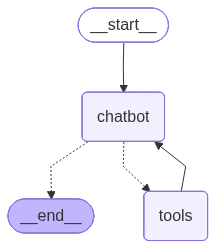

In [30]:
# Let's visualize the graph we've built. We'll use the same code as in the previous video.
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [31]:
while True:
    user_input = input('User: ')
    if user_input.lower() in ['quit', 'exit', 'bye',  'q']:
        print('Goodbye!')
        break
        
    for event in graph.stream({'messages': ('user', user_input)}):
        for value in event.values():
            print('Assistant: ', value['messages'][-1].content)
        print('-' * 50)



Assistant:  
--------------------------------------------------
Assistant:  [{"title": "Positional Encodings in Transformer Models", "url": "https://machinelearningmastery.com/positional-encodings-in-transformer-models/", "content": "## Understanding Positional Encodings\n\nConsider these two sentences: “The fox jumps over the dog” and “The dog jumps over the fox”. They contain the same words but in different orders. In recurrent neural networks, the model processes words sequentially, naturally capturing this difference. However, transformer models process all words in parallel, making them unable to distinguish between these sentences without additional information.\n\nPositional encodings solve this problem by providing information about each token’s position in the sequence. Each token is converted into a vector through the model’s embedding layer, with the vector size called the “hidden dimension”. Positional encoding adds position information by creating a vector of the same hidd

##  Adding Memory to the Chatbot

### Persistent Memory with Checkpointers

**Problem:** Previous chatbots forget everything after the conversation ends.

**Solution:** Add a **checkpointer** to persist conversation state.

**Key Concepts:**

**1. Checkpointer/Saver**
```python
memory = SqliteSaver.from_conn_string(':memory:')
graph = graph_builder.compile(checkpointer=memory)
```
- **SqliteSaver** - Stores state in SQLite database
- **MemorySaver** - Stores state in memory (lost on restart)
- `:memory:` - In-memory SQLite (fast, temporary)
- For persistence, use a file path: `'checkpoints.db'`

**2. Thread IDs (Conversation Sessions)**
```python
config = {'configurable': {'thread_id': '1'}}
```
- Each conversation thread has a unique ID
- Multiple users = multiple thread IDs
- Same thread ID = same conversation history
- Different thread ID = fresh conversation

**3. How It Works**
- After each turn, state is saved (checkpointed)
- On next message, previous state is loaded
- Agent remembers all previous messages in that thread
- Can have multiple concurrent conversations with different thread IDs

**Memory Benefits:**
- Multi-turn conversations with context
- Reference previous questions/answers
- Build complex reasoning over time
- Enable follow-up questions

**Example Flow:**
```python
# First question
graph.stream({'messages': [('user', 'What is LangGraph?')]}, 
             config={'configurable': {'thread_id': '1'}})

# Follow-up (agent remembers first question!)
graph.stream({'messages': [('user', 'How do I use it?')]}, 
             config={'configurable': {'thread_id': '1'}})
```

In [32]:
pip install -q langgraph-checkpoint-sqlite

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Loading Tavily API key from .env (still needed for Tavily search)
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [34]:
from langgraph.graph import StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=3)
tools = [tool]

llm = ChatOllama(model='llama3.2', temperature=0.5)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node('chatbot', chatbot)
tool_node = ToolNode(tools=[tool])
graph_builder.add_node('tools', tool_node)

graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition,
)

graph_builder.add_edge('tools', 'chatbot')
graph_builder.set_entry_point('chatbot')

In [35]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver ### fix

memory = SqliteSaver.from_conn_string(':memory:')
graph = graph_builder.compile(checkpointer=MemorySaver()) ### fix


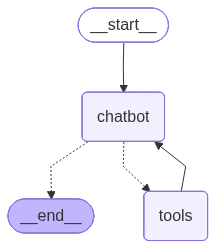

In [36]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
config = {'configurable': {'thread_id': '1'}}

In [38]:
prompt = 'What is the lastest AI model developed by OpenAI?'

# streaming the events. 
events = graph.stream(
    {'messages': [('user', prompt)]}, config, stream_mode='values'
)

for event in events:
    event['messages'][-1].pretty_print()


================================ Human Message =================================

What is the lastest AI model developed by OpenAI?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (21890030-d6cd-4bd2-a2bb-581b840f756a)
 Call ID: 21890030-d6cd-4bd2-a2bb-581b840f756a
  Args:
    query: latest ai model openai
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Model Release Notes - OpenAI Help Center", "url": "https://help.openai.com/en/articles/9624314-model-release-notes", "content": "Introducing OpenAI o3-mini (January 31, 2025). We're excited to release o3-mini, our newest cost-efficient reasoning model optimized for coding, math, and", "score": 0.78709817}, {"title": "Models | OpenAI API", "url": "https://developers.openai.com/api/docs/models", "content": "o3\no4-mini\ngpt-4.1\ngpt-4.1-mini\ngpt-4.1-nano\no1-pro\ncomputer-use-preview\ngp

In [39]:
# It has memory!
prompt = 'What about Google?'
events = graph.stream(
    {'messages': [('user', prompt)]}, config, stream_mode='values'
)
for event in events:
    event['messages'][-1].pretty_print()


================================ Human Message =================================

What about Google?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (36076b61-85b6-4cf6-8468-3abc685892a8)
 Call ID: 36076b61-85b6-4cf6-8468-3abc685892a8
  Args:
    query: Google
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Google - Wikipedia", "url": "https://en.wikipedia.org/wiki/Google", "content": "Google LLC (/ˈɡuː.ɡəl/ ⓘ, GOO-gəl) is an American multinational technology corporation focused on information technology, online advertising, search engine technology, email, cloud computing, software, quantum computing, e-commerce, consumer electronics, and artificial intelligence (AI). It has been referred to as \"the most powerful company in the world\" by BBC, and is one of the world's most valuable brands. Google's parent company Alphabet Inc. has b

In [40]:
prompt = 'What did I ask you so far?'

events = graph.stream(
    {'messages': [('user', prompt)]}, config, stream_mode='values'
)
for event in events:
    event['messages'][-1].pretty_print()


================================ Human Message =================================

What did I ask you so far?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0dac9bd3-d31e-47d0-9f1f-74e4ffc4befb)
 Call ID: 0dac9bd3-d31e-47d0-9f1f-74e4ffc4befb
  Args:
    query: Google functions
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Google Cloud Functions Explained - Pluralsight", "url": "https://www.pluralsight.com/resources/blog/cloud/google-cloud-functions-explained", "content": "## Google Cloud Functions: An Introduction\n\nGoogle Cloud Functions is a serverless compute platform that allows you to run code in response to events without having to provision or manage servers. Because Cloud Function is a fully managed service, it is a great way to efficiently automate tasks, build microservices, and connect your applications to other cloud pr

In [41]:
# NEW THREAD => no memory
config1 = {"configurable": {"thread_id": "10"}}

prompt = 'What did I ask you so far?'

events = graph.stream(
    {"messages": [("user", prompt)]}, config1, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

What did I ask you so far?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (cfd6a049-63e3-4912-9534-57ed334871c3)
 Call ID: cfd6a049-63e3-4912-9534-57ed334871c3
  Args:
    query: your question so far
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "So far, do you have any questions? : r/EnglishLearning - Reddit", "url": "https://www.reddit.com/r/EnglishLearning/comments/76rnus/so_far_do_you_have_any_questions/", "content": "r/EnglishLearning icon\n\n# So far, do you have any questions?\n\nAnswer: below\n\nI'm presenting something. Intermittently I asked as this;\n\nSo far, do you have any questions?\n\nIs it okay to use \"so far\" with \"do you have any questions\"? Yes\n\nAfter saying it, I became unsure. But I already said it. So I was like 'what am I t

In [42]:
snapshot = graph.get_state(config)
snapshot


StateSnapshot(values={'messages': [HumanMessage(content='What is the lastest AI model developed by OpenAI?', additional_kwargs={}, response_metadata={}, id='fb4ad7c6-46f9-4bbe-8c4e-45d65655a297'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-02-27T12:31:39.359905Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5935041400, 'load_duration': 5188234000, 'prompt_eval_count': 198, 'prompt_eval_duration': 293056100, 'eval_count': 21, 'eval_duration': 442500200, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019c9f15-362d-7922-9612-a406eefacf81-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest ai model openai'}, 'id': '21890030-d6cd-4bd2-a2bb-581b840f756a', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 198, 'output_tokens': 21, 'total_tokens': 219}), ToolMessage(content='[{"title": "Model Release Notes - OpenAI Help Center", 

In [43]:
snapshot.next

()